In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import sys, os, time, math
import functools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn import decomposition
from sklearn import datasets

from datasets import DataGenerator, DataGeneratorSymmetric, generate_multiv_gauss
from vae import  VAE_vanilla, VAE_known, vae_vanilla_loss, vae_known_loss
from logger import Logger
from IPython import display

In [101]:
DATA_DIM = 5
LATENT_DIM = 2
MAX_ITER = 100000
BATCH_SIZE = 16

In [102]:
dataset = DataGenerator(data_dim=DATA_DIM, max_iter=MAX_ITER)
dataset_sym = DataGeneratorSymmetric(data_dim=DATA_DIM, max_iter=MAX_ITER)

In [103]:
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2)
data_loader_sym = DataLoader(dataset_sym, batch_size=BATCH_SIZE, num_workers=2)

# VAE vanilla training

In [6]:
vae_model = VAE_vanilla(data_dim=DATA_DIM,latent_dim=LATENT_DIM)
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-6, amsgrad=True)

logger_vanilla = Logger(name="VAE vanilla")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vanilla.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

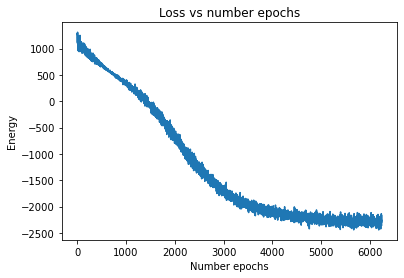

In [7]:
for data_batch in data_loader:
    loss = vae_vanilla_loss(data_batch, vae_model)
    vae_model.step(loss)
    display.clear_output(wait=True)
    logger_vanilla.update("loss", loss)

In [8]:
data_iter = iter(data_loader)
max_iter = 4
real_data = next(data_iter)
for i in range(max_iter):
    new_data = next(data_iter)
    real_data = torch.cat((real_data, new_data))

In [9]:
mean = torch.zeros(LATENT_DIM)
cov = torch.eye(LATENT_DIM)
max_iter = 1
z_samples = generate_multiv_gauss(real_data.shape[0]//max_iter, mean, cov)
generation_dists = vae_model.decoder(z_samples)
generated_data = generation_dists.sample() 

In [10]:
for i in range(max_iter):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [11]:
real_data = real_data.numpy()
generated_data = generated_data.numpy()

In [12]:
data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [13]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

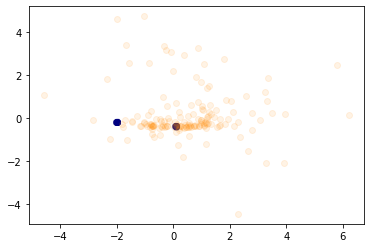

In [14]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.1)

plt.show()

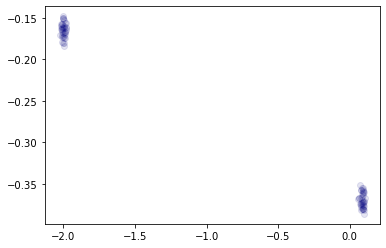

In [15]:
plt.scatter(data_proj[labels==0, 0], data_proj[labels==0, 1], 
                color="navy",
                alpha=0.1)
plt.show()

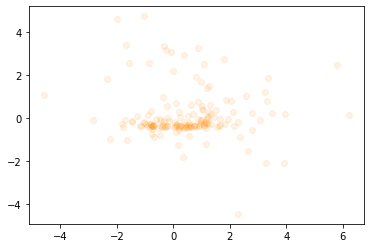

In [16]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()

# VAE everything known

In [104]:
DATA_DIM = DATA_DIM
LATENT_DIM = 1
vae_model = VAE_known(data_dim=DATA_DIM,latent_dim=LATENT_DIM)
vae_model.compile(torch.optim.Adam, lr=3e-5, weight_decay=2e-4, amsgrad=True)

logger_vae_known = Logger(name="VAE everything known")
plt_opts = {
    "feature": "loss",
    "xlabel": "Number epochs",
    "ylabel": "Energy",
}
plot_name = "Loss vs number epochs"
logger_vae_known.add_hook(lambda logger, data:logger.plot(data, plot_name, opts=plt_opts),
                        feature="loss", freq=40)

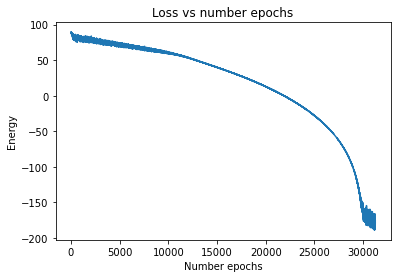

In [125]:
for data_batch in data_loader_sym:
    loss = vae_known_loss(data_batch, vae_model)
    vae_model.step(loss)
    display.clear_output(wait=True)
    logger_vae_known.update("loss", loss)

In [126]:
data_iter = iter(data_loader_sym)
max_iter = 4
real_data = next(data_iter)
for i in range(max_iter):
    new_data = next(data_iter)
    real_data = torch.cat((real_data, new_data))

In [127]:
p_bernoulli = 1/2
p_bernoulli_mat = torch.zeros(real_data.shape[0], 1) + p_bernoulli
z_samples = torch.bernoulli(p_bernoulli_mat)
z_samples[z_samples==0] = -1
generation_dists = vae_model.decoder(z_samples)
generated_data = generation_dists.sample() 

In [128]:
for i in range(max_iter):
    new_data = generation_dists.sample()
    generated_data = torch.cat((generated_data, new_data))

In [129]:
real_data = real_data.numpy()
generated_data = generated_data.numpy()

In [130]:
data = np.vstack((real_data, generated_data))
labels = np.ones(len(data))
labels[:len(real_data)] = 0

In [131]:
pca = decomposition.PCA(n_components=2)
data_pca = pca.fit(data)
data_proj = pca.transform(data)

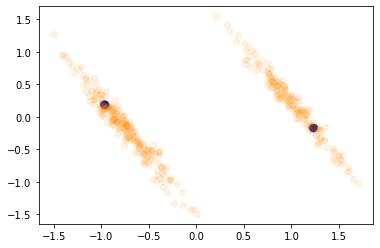

In [132]:
plt.figure()
colors = ['navy', 'darkorange']

for color, i in zip(colors, [0, 1]):
    plt.scatter(data_proj[labels==i, 0], data_proj[labels==i, 1], 
                color=color,
                alpha=0.1)

plt.show()

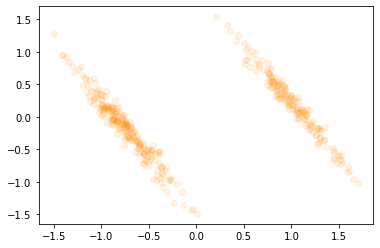

In [133]:
plt.scatter(data_proj[labels==1, 0], data_proj[labels==1, 1], 
                color="darkorange",
                alpha=0.1)
plt.show()